In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

df = pd.read_csv('data/5g_vanet_dataset.csv')
print(df.head())


   Vehicle_ID Vehicle_Type                   Timestamp   Latitude  Longitude  \
0           1          car  2024-09-18 11:18:32.548082  12.974220  77.689259   
1           1          car  2024-09-18 11:18:42.548082  12.975204  77.689494   
2           1          car  2024-09-18 11:18:52.548082  12.974670  77.688675   
3           1          car  2024-09-18 11:19:02.548082  12.975568  77.689606   
4           1          car  2024-09-18 11:19:12.548082  12.976386  77.689124   

    Speed_kmh  Direction_deg  Congestion_Level  Vehicle_Density  Energy_Used  \
0   71.839018      56.166711                87               36     0.800047   
1  112.626325       0.280356                57               22     0.134625   
2    5.599880     350.551987                61               44     2.619749   
3   20.462895      23.418573                 8               26     0.578593   
4   59.421229      12.379868                 3                2     2.183264   

   Remaining_Energy  Is_Malicious Atta

In [2]:
# Creazione del profilo comportamentale (Behavioral Profile)
v_behavior = df.groupby('Vehicle_ID').agg({
    'Energy_Used': ['mean', 'max', 'std'],
    'Speed_kmh': ['mean', 'std'],
    'Throughput_Mbps': 'mean',
    'Is_Malicious': 'max'
})

# Appiattimento e Feature Engineering
v_behavior.columns = ['_'.join(col).strip() for col in v_behavior.columns.values]

# Nuova feature: Costo energetico della comunicazione
v_behavior['Energy_Intensity'] = v_behavior['Energy_Used_mean'] / (v_behavior['Throughput_Mbps_mean'] + 1e-5)

# Nuova feature: Indice di mobilità instabile
# Un valore alto indica un veicolo che cambia velocità bruscamente (potrebbe essere correlato a attacchi mobili)
v_behavior['Mobility_Instability'] = v_behavior['Speed_kmh_std'] / (v_behavior['Speed_kmh_mean'] + 1e-5)

X_behavior = v_behavior[['Energy_Used_max', 'Energy_Used_std', 'Energy_Intensity', 'Mobility_Instability']].fillna(0)

In [3]:
# Scaling
X_scaled_beh = StandardScaler().fit_transform(X_behavior)

# Cerchiamo 3 profili: Normale, Eco (basso consumo), Sospetto (alto consumo/instabile)
kmeans_beh = KMeans(n_clusters=3, random_state=42)
v_behavior['Behavior_Cluster'] = kmeans_beh.fit_predict(X_scaled_beh)

# Analisi dei profili
print("--- ANALISI DEI PROFILI COMPORTAMENTALI ---")
summary = v_behavior.groupby('Behavior_Cluster').agg({
    'Is_Malicious_max': ['count', 'mean'],
    'Energy_Intensity': 'mean',
    'Mobility_Instability': 'mean'
})
print(summary)

--- ANALISI DEI PROFILI COMPORTAMENTALI ---
                 Is_Malicious_max           Energy_Intensity  \
                            count      mean             mean   
Behavior_Cluster                                               
0                            1751  0.189035         0.484624   
1                            1145  0.172052         0.421194   
2                            2104  0.193916         0.555943   

                 Mobility_Instability  
                                 mean  
Behavior_Cluster                       
0                            0.710432  
1                            0.583575  
2                            0.486927  


C:\Users\GABRIELE\AppData\Local\Temp\ipykernel_66508\1343172261.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=v_behavior, x='Is_Malicious_max', y='Energy_Intensity', palette='coolwarm')


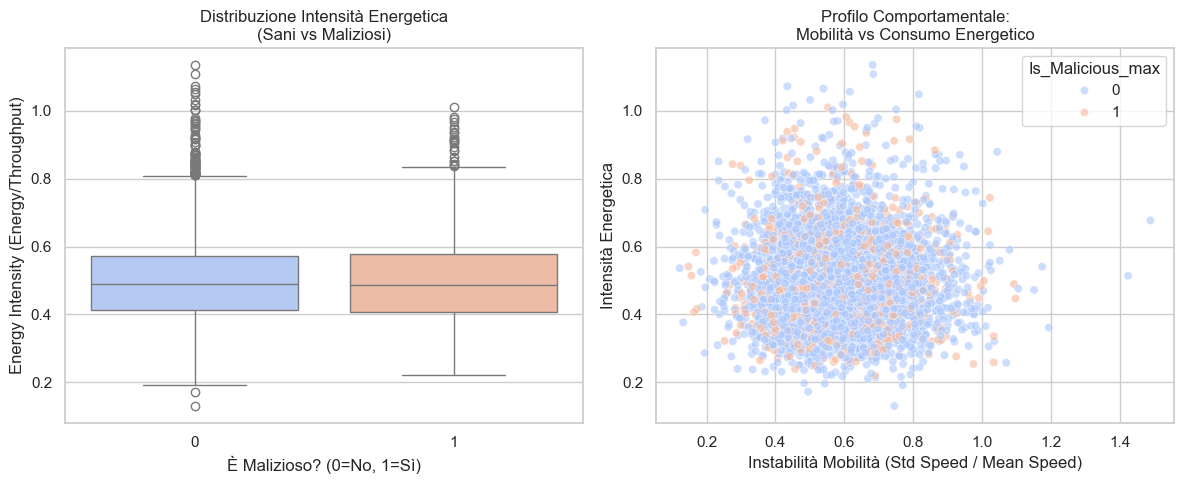

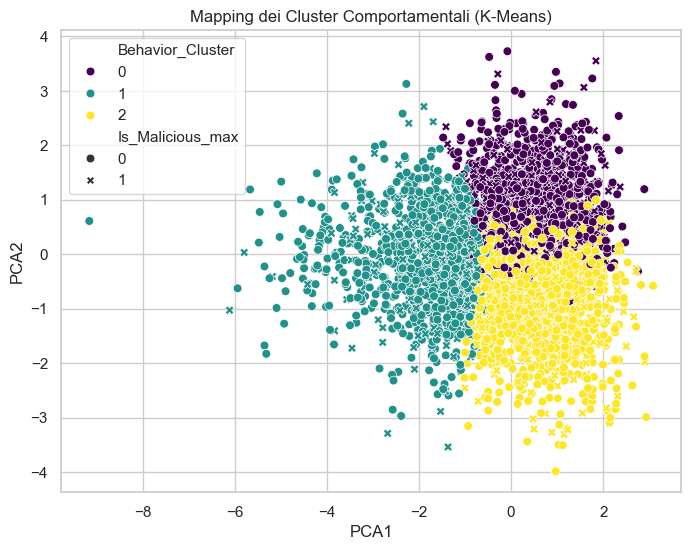

In [4]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=v_behavior, x='Is_Malicious_max', y='Energy_Intensity', palette='coolwarm')
plt.title('Distribuzione Intensità Energetica\n(Sani vs Maliziosi)')
plt.xlabel('È Malizioso? (0=No, 1=Sì)')
plt.ylabel('Energy Intensity (Energy/Throughput)')

#Scatter Plot: Mobilità vs Energia
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=v_behavior, 
    x='Mobility_Instability', 
    y='Energy_Intensity', 
    hue='Is_Malicious_max', 
    alpha=0.6, 
    palette='coolwarm'
)
plt.title('Profilo Comportamentale:\nMobilità vs Consumo Energetico')
plt.xlabel('Instabilità Mobilità (Std Speed / Mean Speed)')
plt.ylabel('Intensità Energetica')

plt.tight_layout()
plt.show()

#Visualizzazione dei Cluster Comportamentali (PCA)
pca_beh = PCA(n_components=2)
X_pca_beh = pca_beh.fit_transform(X_scaled_beh)
v_behavior['PCA1'] = X_pca_beh[:, 0]
v_behavior['PCA2'] = X_pca_beh[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=v_behavior, 
    x='PCA1', 
    y='PCA2', 
    hue='Behavior_Cluster', 
    style='Is_Malicious_max', 
    palette='viridis', 
    s=40
)
plt.title('Mapping dei Cluster Comportamentali (K-Means)')
plt.show()


--- IDENTIKIT DEI CLUSTER COMPORTAMENTALI ---
                  Malicious_Rate  Energy_Used_mean  Energy_Intensity  \
Behavior_Cluster                                                       
0                         0.1890            2.5537            0.4846   
1                         0.1721            2.2277            0.4212   
2                         0.1939            2.7156            0.5559   

                  Mobility_Instability  Speed_kmh_mean  Throughput_Mbps_mean  
Behavior_Cluster                                                              
0                               0.7104         53.1676                5.3961  
1                               0.5836         60.0722                5.4111  
2                               0.4869         65.7764                5.0346  


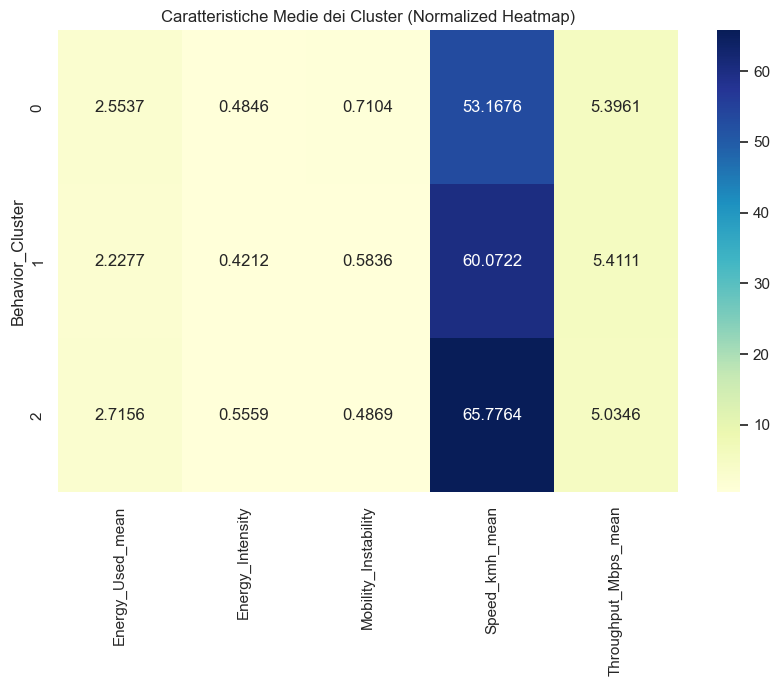

In [ ]:
# 1. Calcoliamo i valori medi per ogni cluster comportamentale
cluster_profile = v_behavior.groupby('Behavior_Cluster').agg({
    'Is_Malicious_max': 'mean',          # Percentuale di attaccanti nel cluster
    'Energy_Used_mean': 'mean',          # Consumo medio
    'Energy_Intensity': 'mean',          # Efficienza (Energy/Throughput)
    'Mobility_Instability': 'mean',      # Instabilità guida
    'Speed_kmh_mean': 'mean',            # Velocità media
    'Throughput_Mbps_mean': 'mean'       # Quantità dati scambiati
}).rename(columns={'Is_Malicious_max': 'Malicious_Rate'})

# 2. Arrotondiamo per una lettura più semplice
print("\n--- IDENTIKIT DEI CLUSTER COMPORTAMENTALI ---")
print(cluster_profile.round(4))

# 3. Visualizzazione con Heatmap 
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_profile.drop(columns=['Malicious_Rate']), annot=True, cmap='YlGnBu', fmt='.4f')
plt.title('Caratteristiche Medie dei Cluster (Normalized Heatmap)')
plt.show()